# Differentially private random feature models

Compare with DP_RF and normalized RLS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time

from scipy import io
from matplotlib import cm

In [2]:
def RF_Gaussian(gamma, N, x_train, x_test):
    """
    Generate Gaussian Random Features.
    
    Inputs:
    gamma: (2*gamma)**0.5 is the variance of the Gaussian distribution
    N: number of random features
    x_train: training samples of shape m x d
    x_test: test samples of shape m' x d
    
    Outputs:
    A_train: Training Random Feature Map A_train
    A_test: Test random feature map A_test
    """
    # number of samples and dimension of features
    m,d = x_train.shape
    # random features generated from Cauchy distribution with scaling parameter gamma
    Omega = np.random.normal(loc = 0, scale = (2.0 * gamma) ** 0.5, size = (d,N))
    # Random feature matrix A
    random_offset = np.random.uniform(0, 2 * np.pi, size=(1,N))
    A_train = np.cos(x_train@Omega + random_offset)
    A_test = np.cos(x_test@Omega + random_offset)
    
    return A_train * (2.0 / N) ** 0.5, A_test * (2.0 / N) ** 0.5


def private(c, Delta_c, epsilon, mechanism="Laplace"):
    """
    Generate private coefficients
    
    Inputs:
    c: non-private coefficient
    Delta_c: l2-sensitivity
    epsilon: privace budget
    mechanism: Three different mechinisms
    
    Output:
    c_private: private coefficients
    """
    N = c.shape[0]
    
    if mechanism == "Laplace":
        
        Z = np.random.laplace(loc=0.0, scale=Delta_c/epsilon, size=c.shape)
        return c+Z
    
    elif mechanism == "Gaussian":
        
        Z = np.random.normal(loc=0.0, scale=5*Delta_c/np.sqrt(2*epsilon), size=c.shape)
        return c+Z
    
    elif mechanism == "Gamma":
                
        R = np.random.gamma(N, scale = Delta_c/epsilon)
        Z = np.random.normal(0, 1, size = c.shape)
        L2Lap = R * (Z / np.linalg.norm(Z))
        
        return c+L2Lap

def objective_perturb(epsilon, c, X, y, lamb):
    
    m, N = X.shape
    
    if (lamb == 0) or ((epsilon - np.log(1+ 2*c/m/lamb + c**2/m**2/lamb**2))<=0):
        
        Delta = c/(m* (np.exp(epsilon/4) - 1)) - lamb
        epsilon_prime = epsilon/2
        
    else:
        
        Delta = 0
        epsilon_prime = epsilon - np.log(1+ 2*c/m/lamb + c**2/m**2/lamb**2)
        
    R = np.random.gamma(N, scale = 2/epsilon_prime)
    Z = np.random.normal(0, 1, size = (N,))
    b = R * (Z / np.linalg.norm(Z))
    
    return np.linalg.solve(2*X.T@X/m + (2*lamb+Delta) * np.identity(N), 2*X.T@y/m - b/m)


def excessive_risk(estimator, X, y, Delta_c, epsilon, mechanism):
    
    """
    Compute excessive risk.
    Inputs:
    estimator: non-private estimator.
    X: features.
    y: labels.
    Delta_c: ell_2 sensitivity.
    epsilon: privacy budget.
    mechanism: DP mechanism, Gaussian, gamma, or Laplace.
    Returns:
    excessive risk: a real number.
    """
    
    T = 100      # create T private estimators
    error = 0
    for t in range(T):
        private_estimator = private(estimator, Delta_c, epsilon, mechanism)
        
        error = error + np.linalg.norm(X@private_estimator - y)**2 / np.size(y)
    
    excessive_risk = error / T - np.linalg.norm(X@estimator - y)**2 / np.size(y)
    
    return excessive_risk



## Wine quality dataset

In [3]:
def wine_processing(df1, df2, m, gamma, N, train_size=0.8):
    
    """
    Generate data matrices for random feature and regularized least square.
    df1, df2 are two data frames and m is the sample for each group.
    gamma: scale of Gaussian random feature
    N: number of random features
    """
    
    ## downsampling and change to numpy array
    red_down = red.sample(n=m, replace=False)
    white_down = white.sample(n=m, replace=False)
    
    X_red = red_down.to_numpy()
    X_white = white_down.to_numpy()
    
    ## features and labels 
    X1 = X_red[:, :11]
    X2 = X_white[:,:11]
    
    ## create training and test datasets for each group: 20% of m are for testing
    m_train = int(train_size*m)
    X1_train = X1[:m_train, :]
    X1_test = X1[m_train:,:]

    X2_train = X2[:m_train, :]
    X2_test = X2[m_train:,:]

    X_train = np.row_stack((X1_train, X2_train))
    X_test = np.row_stack((X1_test, X2_test))
    
    ## Generate random feature matrix 
    A_train, A_test = RF_Gaussian(gamma, N, X_train, X_test)
    
    ## normalize data matrix
    mmscaler = MinMaxScaler()
    X1_normalized = mmscaler.fit_transform(X_red)
    mmscaler = MinMaxScaler()
    X2_normalized = mmscaler.fit_transform(X_white)
    
    X1 = X1_normalized[:, :11]
    y1 = X1_normalized[:, -1]
    X2 = X2_normalized[:,:11]
    y2 = X2_normalized[:, -1]
    
    ## Generate train test data fr each group
    X1_train = X1[:m_train, :]
    X1_test = X1[m_train:,:]
    y1_train = y1[:m_train]
    y1_test = y1[m_train:]
    
    X2_train = X2[:m_train, :]
    X2_test = X2[m_train:,:]
    y2_train = y2[:m_train]
    y2_test = y2[m_train:]
    
    X_train_normalized = np.row_stack((X1_train, X2_train))
    X_test_normalized = np.row_stack((X1_test, X2_test))
    y_train = np.concatenate((y1_train, y2_train))
    y_test = np.concatenate((y1_test,y2_test))
    
    ## Generate augmented matrix and split to each group
    X_train_aug = np.column_stack((X_train_normalized, np.ones( (X_train_normalized.shape[0],1)) ))
    X_test_aug = np.column_stack((X_test_normalized, np.ones((X_test_normalized.shape[0],1))))
    
    return A_train, A_test, X_train_aug, X_test_aug, y_train, y_test

In [4]:
################# Data processing

## Load dataset
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=";")

# number of samples for each group
m = 1500
train_size = 1/3
m_train = int(train_size*m)
m_test = m - m_train

## some hyperparameters
gamma = 10
N = 4000
epsilon_range = np.linspace(0.05,0.3,20)
Delta_c = 4/np.sqrt(N)
mechanism = "Gaussian"

#################### Excessive risk gap (erg)
# Iterate over training and testing K times
K = 10

# excessive risk gap for training and testing: RF and RLS models
erg1_train_RF = np.zeros((K,20))
erg2_train_RF = np.zeros((K,20))
erg1_test_RF = np.zeros((K,20))
erg2_test_RF = np.zeros((K,20))

erg1_train_RLS = np.zeros((K,20))
erg2_train_RLS = np.zeros((K,20))
erg1_test_RLS = np.zeros((K,20))
erg2_test_RLS = np.zeros((K,20))

In [5]:
for k in range(K):
    
    A_train, A_test, X_train_aug, X_test_aug, y_train, y_test = wine_processing(red, white, m, gamma, N, train_size=train_size)
    
    # split random feature matrix to two groups
    A_train_1 = A_train[:m_train,:]
    A_train_2 = A_train[m_train:,:]
    A_test_1 = A_test[:m_test,:]
    A_test_2 = A_test[m_test:,:]
    
    # split augmented matrix to two groups
    X_train1_aug = X_train_aug[:m_train,:]
    X_train2_aug = X_train_aug[m_train:,:]
    X_test1_aug = X_test_aug[:m_test,:]
    X_test2_aug = X_test_aug[m_test:,:]
    
    # split labels to two groups
    y1_train = y_train[:m_train]
    y2_train = y_train[m_train:]
    y1_test = y_test[:m_test]
    y2_test = y_test[m_test:]
    
    ## non-private RF estimator
    coef_rf = np.linalg.pinv(A_train) @ y_train
    
    ## non-private RLS estimator
    lamb = np.sqrt(N)/(4*m_train)      # to make the same variance, we have \lambda = \sqrt(N) / (2m) where m is the number of training samples
    coef_LR = np.linalg.solve( X_train_aug.T @ X_train_aug + lamb * np.eye(X_train_aug.shape[1]), X_train_aug.T @ y_train)

    
    # To estimate excessive risk, we run 100 examples
    for i in range(20):
        
        epsilon = epsilon_range[i]
    
        # Random feature private estimator: training excessive risk
        R_D = excessive_risk(coef_rf, A_train, y_train, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_rf, A_train_1, y1_train, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_rf, A_train_2, y2_train, Delta_c, epsilon, mechanism)
        erg1_train_RF[k,i] = abs(R_D - R_D_1) 
        erg2_train_RF[k,i] = abs(R_D - R_D_2) 
        
        # Random feature private estimator: test excessive risk
        R_D = excessive_risk(coef_rf, A_test, y_test, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_rf, A_test_1, y1_test, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_rf, A_test_2, y2_test, Delta_c, epsilon, mechanism)
        erg1_test_RF[k,i] = abs(R_D - R_D_1)
        erg2_test_RF[k,i] = abs(R_D - R_D_2)
        
        # RLS: training excessive risk
        R_D = excessive_risk(coef_LR, X_train_aug, y_train, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_LR, X_train1_aug, y1_train, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_LR, X_train2_aug, y2_train, Delta_c, epsilon, mechanism)
        erg1_train_RLS[k,i] = abs(R_D - R_D_1) 
        erg2_train_RLS[k,i] = abs(R_D - R_D_2) 
        
        # RLS: test excessive risk
        R_D = excessive_risk(coef_LR, X_test_aug, y_test, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_LR, X_test1_aug, y1_test, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_LR, X_test2_aug, y2_test, Delta_c, epsilon, mechanism)
        erg1_test_RLS[k,i] = abs(R_D - R_D_1) 
        erg2_test_RLS[k,i] = abs(R_D - R_D_2) 


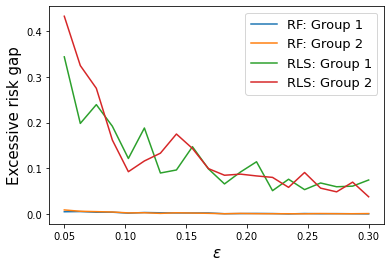

In [6]:
plt.plot(epsilon_range, np.mean(erg1_train_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RF, axis=0), label='RF: Group 2')
plt.plot(epsilon_range, np.mean(erg1_train_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('wine_train.pdf', bbox_inches = 'tight')

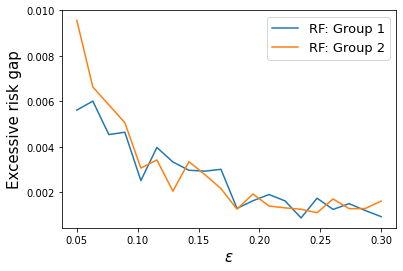

In [7]:
plt.plot(epsilon_range, np.mean(erg1_train_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RF, axis=0), label='RF: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('wine_train_RF.pdf', bbox_inches = 'tight')

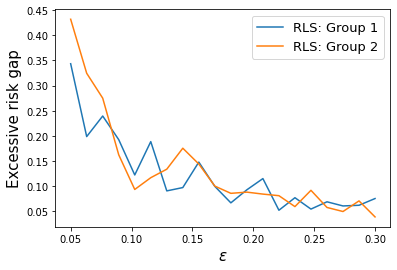

In [8]:
plt.plot(epsilon_range, np.mean(erg1_train_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('wine_train_RLS.pdf', bbox_inches = 'tight')

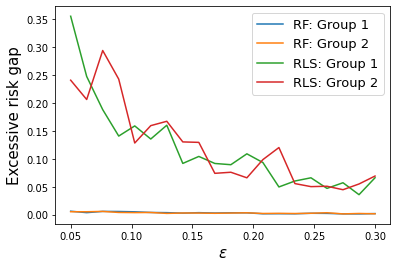

In [9]:
plt.plot(epsilon_range, np.mean(erg1_test_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RF, axis=0), label='RF: Group 2')
plt.plot(epsilon_range, np.mean(erg1_test_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('wine_test.pdf', bbox_inches = 'tight')

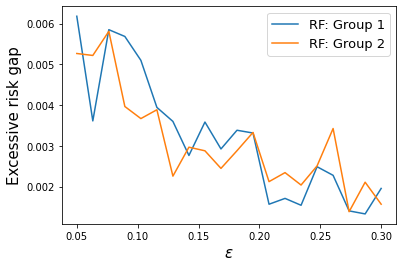

In [10]:
plt.plot(epsilon_range, np.mean(erg1_test_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RF, axis=0), label='RF: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('wine_test_RF.pdf', bbox_inches = 'tight')

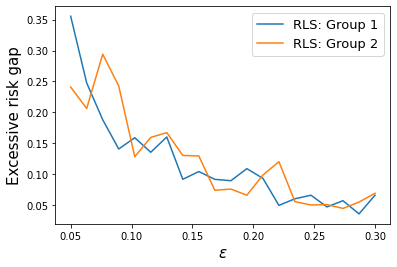

In [11]:
plt.plot(epsilon_range, np.mean(erg1_test_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('wine_test_RLS.pdf', bbox_inches = 'tight')

## Insurance dataset: sex

In [12]:
################ Preprocessing

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def numeric_scaler_numpy(arr):
    '''
    arr (numpy array):  
    '''
    mmscaler = MinMaxScaler()
    scaled_arr = mmscaler.fit_transform(arr)
    return scaled_arr
    

In [13]:
######## Data processing:
df_medical = pd.read_csv('insurance.csv')
df1 = df_medical[df_medical["sex"] == "male"]
df2 = df_medical[df_medical["sex"] == "female"]

# normalize charges
numeric_all = ['charges']
cat_all = ['sex', 'smoker', 'region']

# minmax scaling for charges
df1_mm = numeric_scaler(df1, numeric_all) 
df2_mm = numeric_scaler(df2, numeric_all)

# one-hot encoding for categorical data
df1_mm_oh = one_hot(df1_mm, cat_all)
df2_mm_oh = one_hot(df2_mm, cat_all)
# drop the categorics that were used to one hot encode
df1_mm_oh.drop(cat_all, axis = 1, inplace=True) 
df2_mm_oh.drop(cat_all, axis = 1, inplace=True)
# make bool true, false into 1.0, 0.0
df1_mm_oh = df1_mm_oh * 1.0 
df2_mm_oh = df2_mm_oh * 1.0

# data matrix for each group
X1 = df1_mm_oh.drop('charges', axis=1)
X1 = X1.to_numpy() 
y1 = df1_mm_oh['charges'].to_numpy()
X2 = df2_mm_oh.drop('charges', axis=1)
X2 = X2.to_numpy() 
y2 = df2_mm_oh['charges'].to_numpy()

# some parameters
gamma = 1e-5
N = 4000
epsilon_range = np.linspace(0.05,0.3,20)
Delta_c = 4/np.sqrt(N)
mechanism = "Gaussian"

#################### Excessive risk gap (erg)
# Iterate over training and testing K times
K = 10

# excessive risk gap for training and testing: RF model
erg1_train_RF = np.zeros((K,20))
erg2_train_RF = np.zeros((K,20))
erg1_test_RF = np.zeros((K,20))
erg2_test_RF = np.zeros((K,20))

In [14]:
for k in range(K):
    
    # train test split for each group
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.1)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.1)
    
    # training and test dataset
    X_train = np.row_stack((X1_train, X2_train))
    X_test = np.row_stack((X1_test, X2_test))
    y_train = np.concatenate((y1_train, y2_train))
    y_test = np.concatenate((y1_test,y2_test))
    
    m_test_1 = X1_test.shape[0]
    m_test = X_test.shape[0]
    
    m_train_1 = X1_train.shape[0]
    m_train = X_train.shape[0]
    
    ###################### Random Feature model
    A_train, A_test = RF_Gaussian(gamma, N, X_train, X_test)
    A_train_1 = A_train[:m_train_1,:]
    A_train_2 = A_train[m_train_1:,:]
    
    A_test_1 = A_test[:m_test_1,:]
    A_test_2 = A_test[m_test_1:,:]
    
    # non-private estimator
    coef_rf = np.linalg.pinv(A_train) @ y_train
     
    # To estimate excessive risk, we run 100 examples
    for i in range(20):
        
        epsilon = epsilon_range[i]
    
        # Random feature private estimator: training excessive risk
        R_D = excessive_risk(coef_rf, A_train, y_train, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_rf, A_train_1, y1_train, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_rf, A_train_2, y2_train, Delta_c, epsilon, mechanism)
        erg1_train_RF[k,i] = abs(R_D - R_D_1) 
        erg2_train_RF[k,i] = abs(R_D - R_D_2) 
        
        # Random feature private estimator: test excessive risk
        R_D = excessive_risk(coef_rf, A_test, y_test, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_rf, A_test_1, y1_test, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_rf, A_test_2, y2_test, Delta_c, epsilon, mechanism)
        erg1_test_RF[k,i] = abs(R_D - R_D_1) 
        erg1_test_RF[k,i] = abs(R_D - R_D_2) 

Regularized least square

In [15]:
# normalize charges
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']

# minmax scaling for charges
df1_mm = numeric_scaler(df1, numeric_all) 
df2_mm = numeric_scaler(df2, numeric_all)

# one-hot encoding for categorical data
df1_mm_oh = one_hot(df1_mm, cat_all)
df2_mm_oh = one_hot(df2_mm, cat_all)
# drop the categorics that were used to one hot encode
df1_mm_oh.drop(cat_all, axis = 1, inplace=True) 
df2_mm_oh.drop(cat_all, axis = 1, inplace=True)
# make bool true, false into 1.0, 0.0
df1_mm_oh = df1_mm_oh * 1.0 
df2_mm_oh = df2_mm_oh * 1.0

# data matrix for each group
X1 = df1_mm_oh.drop('charges', axis=1)
X1 = X1.to_numpy() 
y1 = df1_mm_oh['charges'].to_numpy()
X2 = df2_mm_oh.drop('charges', axis=1)
X2 = X2.to_numpy() 
y2 = df2_mm_oh['charges'].to_numpy()

#################### Excessive risk gap (erg)
# Iterate over training and testing K times
K = 10

# excessive risk gap for training and testing: RLS model
erg1_train_RLS = np.zeros((K,20))
erg2_train_RLS = np.zeros((K,20))
erg1_test_RLS = np.zeros((K,20))
erg2_test_RLS = np.zeros((K,20))

In [16]:
for k in range(K):
    
    # train test split for each group
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.1)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.1)
    
    # training and test dataset
    X_train = np.row_stack((X1_train, X2_train))
    X_test = np.row_stack((X1_test, X2_test))
    y_train = np.concatenate((y1_train, y2_train))
    y_test = np.concatenate((y1_test,y2_test))
    
    m_test_1 = X1_test.shape[0]
    m_test = X_test.shape[0]
    
    m_train_1 = X1_train.shape[0]
    m_train = X_train.shape[0]
    
    
    ###################### Linear regression model
    X_train_aug = np.column_stack((X_train, np.ones( (X_train.shape[0],1)) ))
    X_test_aug = np.column_stack((X_test, np.ones((X_test.shape[0],1))))
    
    X_train1_aug = X_train_aug[:m_train_1,:]
    X_train2_aug = X_train_aug[m_train_1:,:]
    
    X_test1_aug = X_test_aug[:m_test_1,:]
    X_test2_aug = X_test_aug[m_test_1:,:]
    
    lamb = np.sqrt(N)/(2*X_train.shape[0])
    coef_LR = np.linalg.solve( X_train_aug.T @ X_train_aug + lamb * np.eye(X_train_aug.shape[1]), X_train_aug.T @ y_train)
    
    # To estimate excessive risk, we run 100 examples
    for i in range(20):
        
        epsilon = epsilon_range[i]
    
        # Random feature private estimator: training excessive risk
        R_D = excessive_risk(coef_LR, X_train_aug, y_train, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_LR, X_train1_aug, y1_train, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_LR, X_train2_aug, y2_train, Delta_c, epsilon, mechanism)
        erg1_train_RLS[k,i] = abs(R_D - R_D_1) 
        erg2_train_RLS[k,i] = abs(R_D - R_D_2) 
        
        # Random feature private estimator: test excessive risk
        R_D = excessive_risk(coef_LR, X_test_aug, y_test, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_LR, X_test1_aug, y1_test, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_LR, X_test2_aug, y2_test, Delta_c, epsilon, mechanism)
        erg1_test_RLS[k,i] = abs(R_D - R_D_1) 
        erg2_test_RLS[k,i] = abs(R_D - R_D_2) 

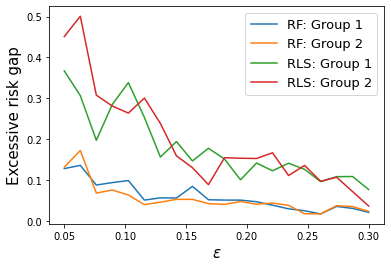

In [17]:
plt.plot(epsilon_range, np.mean(erg1_train_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RF, axis=0), label='RF: Group 2')
plt.plot(epsilon_range, np.mean(erg1_train_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('sex_train.pdf', bbox_inches = 'tight')

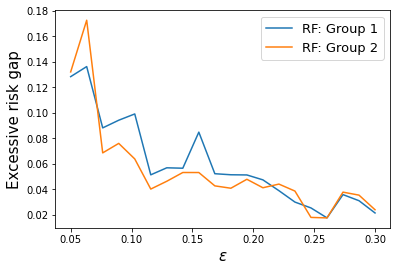

In [18]:
plt.plot(epsilon_range, np.mean(erg1_train_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RF, axis=0), label='RF: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('sex_train_RF.pdf', bbox_inches = 'tight')

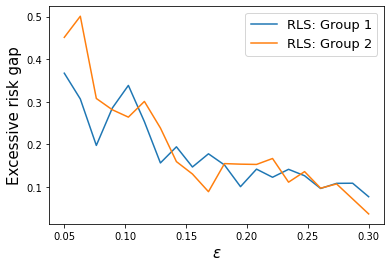

In [19]:
plt.plot(epsilon_range, np.mean(erg1_train_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('sex_train_RLS.pdf', bbox_inches = 'tight')

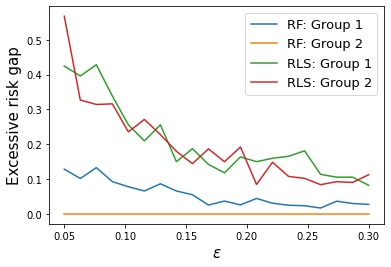

In [20]:
plt.plot(epsilon_range, np.mean(erg1_test_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RF, axis=0), label='RF: Group 2')
plt.plot(epsilon_range, np.mean(erg1_test_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('sex_test.pdf', bbox_inches = 'tight')

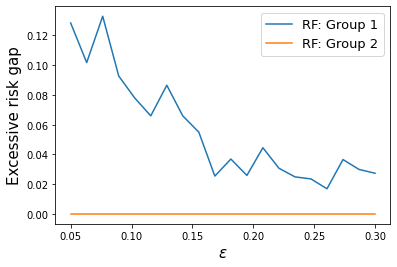

In [21]:
plt.plot(epsilon_range, np.mean(erg1_test_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RF, axis=0), label='RF: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('sex_test_RF.pdf', bbox_inches = 'tight')

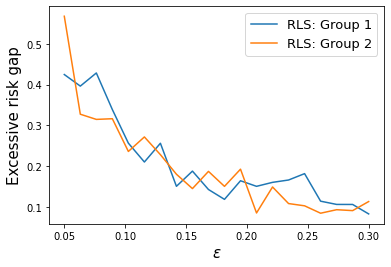

In [22]:
plt.plot(epsilon_range, np.mean(erg1_test_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('sex_test_RLS.pdf', bbox_inches = 'tight')

## Insurance dataset: smoker

In [23]:
######## Data processing:
df_medical = pd.read_csv('insurance.csv')
df1 = df_medical[df_medical["smoker"] == "yes"]
df2 = df_medical[df_medical["smoker"] == "no"]

# normalize charges
numeric_all = ['charges']
cat_all = ['sex', 'smoker', 'region']

# minmax scaling for charges
df1_mm = numeric_scaler(df1, numeric_all) 
df2_mm = numeric_scaler(df2, numeric_all)

# one-hot encoding for categorical data
df1_mm_oh = one_hot(df1_mm, cat_all)
df2_mm_oh = one_hot(df2_mm, cat_all)
# drop the categorics that were used to one hot encode
df1_mm_oh.drop(cat_all, axis = 1, inplace=True) 
df2_mm_oh.drop(cat_all, axis = 1, inplace=True)
# make bool true, false into 1.0, 0.0
df1_mm_oh = df1_mm_oh * 1.0 
df2_mm_oh = df2_mm_oh * 1.0

# data matrix for each group
X1 = df1_mm_oh.drop('charges', axis=1)
X1 = X1.to_numpy() 
y1 = df1_mm_oh['charges'].to_numpy()
X2 = df2_mm_oh.drop('charges', axis=1)
X2 = X2.to_numpy() 
y2 = df2_mm_oh['charges'].to_numpy()

# some parameters
gamma = 1e-5
N = 4000
epsilon_range = np.linspace(0.05,0.3,20)
Delta_c = 4/np.sqrt(N)
mechanism = "Gaussian"

#################### Excessive risk gap (erg)
# Iterate over training and testing K times
K = 10

# excessive risk gap for training and testing: RF model
erg1_train_RF = np.zeros((K,20))
erg2_train_RF = np.zeros((K,20))
erg1_test_RF = np.zeros((K,20))
erg2_test_RF = np.zeros((K,20))

In [24]:
for k in range(K):
    
    # train test split for each group
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.1)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.1)
    
    # training and test dataset
    X_train = np.row_stack((X1_train, X2_train))
    X_test = np.row_stack((X1_test, X2_test))
    y_train = np.concatenate((y1_train, y2_train))
    y_test = np.concatenate((y1_test,y2_test))
    
    m_test_1 = X1_test.shape[0]
    m_test = X_test.shape[0]
    
    m_train_1 = X1_train.shape[0]
    m_train = X_train.shape[0]
    
    ###################### Random Feature model
    A_train, A_test = RF_Gaussian(gamma, N, X_train, X_test)
    A_train_1 = A_train[:m_train_1,:]
    A_train_2 = A_train[m_train_1:,:]
    
    A_test_1 = A_test[:m_test_1,:]
    A_test_2 = A_test[m_test_1:,:]
    
    # non-private estimator
    coef_rf = np.linalg.pinv(A_train) @ y_train
     
    # To estimate excessive risk, we run 100 examples
    for i in range(20):
        
        epsilon = epsilon_range[i]
    
        # Random feature private estimator: training excessive risk
        R_D = excessive_risk(coef_rf, A_train, y_train, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_rf, A_train_1, y1_train, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_rf, A_train_2, y2_train, Delta_c, epsilon, mechanism)
        erg1_train_RF[k,i] = abs(R_D - R_D_1) 
        erg2_train_RF[k,i] = abs(R_D - R_D_2) 
        
        # Random feature private estimator: test excessive risk
        R_D = excessive_risk(coef_rf, A_test, y_test, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_rf, A_test_1, y1_test, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_rf, A_test_2, y2_test, Delta_c, epsilon, mechanism)
        erg1_test_RF[k,i] = abs(R_D - R_D_1) 
        erg1_test_RF[k,i] = abs(R_D - R_D_2) 

Regularized least square

In [25]:
# normalize charges
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']

# minmax scaling for charges
df1_mm = numeric_scaler(df1, numeric_all) 
df2_mm = numeric_scaler(df2, numeric_all)

# one-hot encoding for categorical data
df1_mm_oh = one_hot(df1_mm, cat_all)
df2_mm_oh = one_hot(df2_mm, cat_all)
# drop the categorics that were used to one hot encode
df1_mm_oh.drop(cat_all, axis = 1, inplace=True) 
df2_mm_oh.drop(cat_all, axis = 1, inplace=True)
# make bool true, false into 1.0, 0.0
df1_mm_oh = df1_mm_oh * 1.0 
df2_mm_oh = df2_mm_oh * 1.0

# data matrix for each group
X1 = df1_mm_oh.drop('charges', axis=1)
X1 = X1.to_numpy() 
y1 = df1_mm_oh['charges'].to_numpy()
X2 = df2_mm_oh.drop('charges', axis=1)
X2 = X2.to_numpy() 
y2 = df2_mm_oh['charges'].to_numpy()

#################### Excessive risk gap (erg)
# Iterate over training and testing K times
K = 10

# excessive risk gap for training and testing: RLS model
erg1_train_RLS = np.zeros((K,20))
erg2_train_RLS = np.zeros((K,20))
erg1_test_RLS = np.zeros((K,20))
erg2_test_RLS = np.zeros((K,20))

In [26]:
for k in range(K):
    
    # train test split for each group
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.1)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.1)
    
    # training and test dataset
    X_train = np.row_stack((X1_train, X2_train))
    X_test = np.row_stack((X1_test, X2_test))
    y_train = np.concatenate((y1_train, y2_train))
    y_test = np.concatenate((y1_test,y2_test))
    
    m_test_1 = X1_test.shape[0]
    m_test = X_test.shape[0]
    
    m_train_1 = X1_train.shape[0]
    m_train = X_train.shape[0]
    
    
    ###################### Linear regression model
    X_train_aug = np.column_stack((X_train, np.ones( (X_train.shape[0],1)) ))
    X_test_aug = np.column_stack((X_test, np.ones((X_test.shape[0],1))))
    
    X_train1_aug = X_train_aug[:m_train_1,:]
    X_train2_aug = X_train_aug[m_train_1:,:]
    
    X_test1_aug = X_test_aug[:m_test_1,:]
    X_test2_aug = X_test_aug[m_test_1:,:]
    
    lamb = np.sqrt(N)/(2*X_train.shape[0])
    coef_LR = np.linalg.solve( X_train_aug.T @ X_train_aug + lamb * np.eye(X_train_aug.shape[1]), X_train_aug.T @ y_train)
    
    # To estimate excessive risk, we run 100 examples
    for i in range(20):
        
        epsilon = epsilon_range[i]
    
        # Random feature private estimator: training excessive risk
        R_D = excessive_risk(coef_LR, X_train_aug, y_train, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_LR, X_train1_aug, y1_train, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_LR, X_train2_aug, y2_train, Delta_c, epsilon, mechanism)
        erg1_train_RLS[k,i] = abs(R_D - R_D_1) 
        erg2_train_RLS[k,i] = abs(R_D - R_D_2) 
        
        # Random feature private estimator: test excessive risk
        R_D = excessive_risk(coef_LR, X_test_aug, y_test, Delta_c, epsilon, mechanism)
        R_D_1 = excessive_risk(coef_LR, X_test1_aug, y1_test, Delta_c, epsilon, mechanism)
        R_D_2 = excessive_risk(coef_LR, X_test2_aug, y2_test, Delta_c, epsilon, mechanism)
        erg1_test_RLS[k,i] = abs(R_D - R_D_1) 
        erg2_test_RLS[k,i] = abs(R_D - R_D_2) 

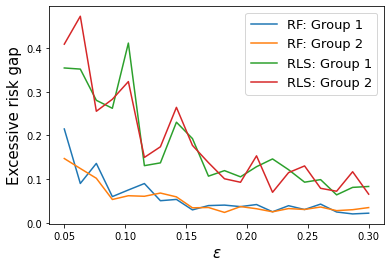

In [27]:
plt.plot(epsilon_range, np.mean(erg1_train_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RF, axis=0), label='RF: Group 2')
plt.plot(epsilon_range, np.mean(erg1_train_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('smoker_train.pdf', bbox_inches = 'tight')

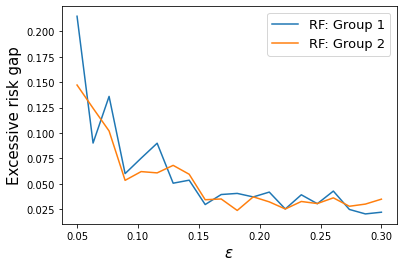

In [28]:
plt.plot(epsilon_range, np.mean(erg1_train_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RF, axis=0), label='RF: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('smoker_train_RF.pdf', bbox_inches = 'tight')

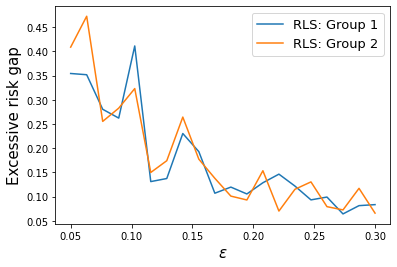

In [29]:
plt.plot(epsilon_range, np.mean(erg1_train_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_train_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('smoker_train_RLS.pdf', bbox_inches = 'tight')

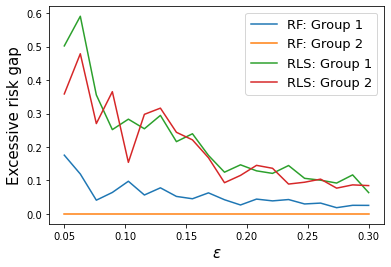

In [30]:
plt.plot(epsilon_range, np.mean(erg1_test_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RF, axis=0), label='RF: Group 2')
plt.plot(epsilon_range, np.mean(erg1_test_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('smoker_test.pdf', bbox_inches = 'tight')

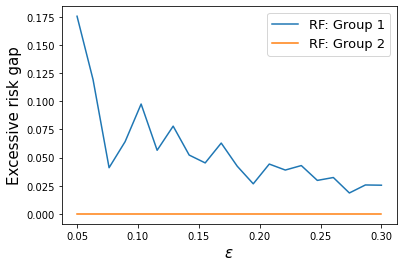

In [31]:
plt.plot(epsilon_range, np.mean(erg1_test_RF, axis=0), label='RF: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RF, axis=0), label='RF: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('smoker_test_RF.pdf', bbox_inches = 'tight')

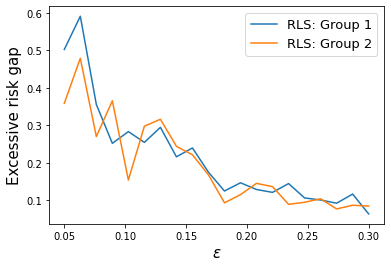

In [32]:
plt.plot(epsilon_range, np.mean(erg1_test_RLS, axis=0), label='RLS: Group 1')
plt.plot(epsilon_range, np.mean(erg2_test_RLS, axis=0), label='RLS: Group 2')
plt.legend(fontsize=13)
plt.xlabel(r'$\epsilon$', size=15)
plt.ylabel('Excessive risk gap', size=15)
plt.savefig('smoker_test_RLS.pdf', bbox_inches = 'tight')